# Signal processing

In [28]:
import math
from time import time

import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sp
import sklearn.mixture as gmm
from scipy.optimize import curve_fit
from scipy.signal import periodogram
from scipy.stats import cauchy, entropy, norm
from sklearn.feature_extraction.text import CountVectorizer

# Import functions from the project. I have no idea how modules work.
import importlib.util

data_fetchers_spec = importlib.util.spec_from_file_location('data_fetchers.py', '../event_detection/data_fetchers.py')
data_fetchers = importlib.util.module_from_spec(data_fetchers_spec)
data_fetchers_spec.loader.exec_module(data_fetchers)

event_detection_spec = importlib.util.spec_from_file_location('main.py', '../event_detection/main.py')
event_detection = importlib.util.module_from_spec(event_detection_spec)
event_detection_spec.loader.exec_module(event_detection)

## Load data

In [46]:
total_time = time()
debug = True

t = time()
documents, relative_days = data_fetchers.fetch_czech_corpus(num_docs=10000000)

stream_length = max(relative_days) + 1  # Zero-based, hence the + 1.
print('Read input in %fs.' % (time() - t))
print('Stream length: %d' % stream_length)

t = time()
vectorizer = CountVectorizer(min_df=30, max_df=100000, binary=True, stop_words=event_detection.CZECH_STOPWORDS)
bow_matrix = vectorizer.fit_transform(documents).tocsr()
id2word = {v: k for k, v in vectorizer.vocabulary_.items()}
print('Created bag of words in %fs.' % (time() - t))
print('BOW:', bow_matrix.shape)

Read input in 20.925460s.
Stream length: 396
Created bag of words in 274.660538s.
BOW: (2090635, 125108)


## Create trajectories

In [47]:
trajectories = event_detection.construct_feature_trajectories(bow_matrix, relative_days, debug=debug)

Constructed DTD matrix in 0.311208s.
DTD: (2090635, 396)
Multiplied bow and dtd matrices in 1.522008s.
DF(t): (125108, 396) float64
N(t): (396,) float64
N: 2090635
DF: (125108,) float64
Constructed word trajectories in 1.221809s.
DF(t)/N(t): (125108, 396) float64
log(N/DF): (125108,) float64
DFIDF(t): (125108, 396) float64


In [92]:
def get_dominant_period(signal):
    freq, pgram = periodogram(signal)
    
    with np.errstate(divide='ignore'):
        period = 1 / freq
    
    dps_index = np.argmax(pgram)
    dp = period[dps_index]
    return dp

## Get some incorrectly classified features

In [48]:
errors = ['predpis', 'pozadavek', 'vyzadat', 'mirny', 'narust', 'energie']

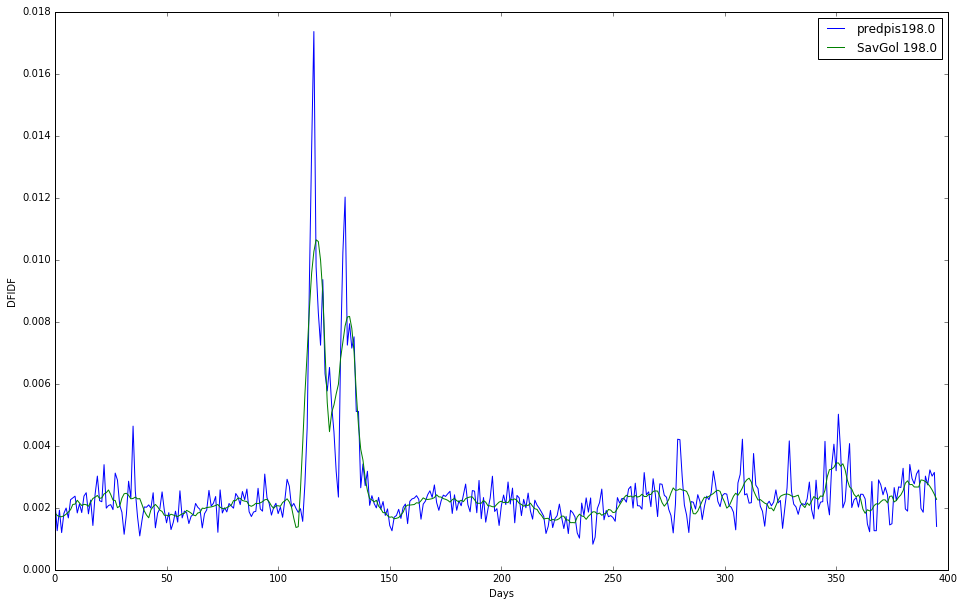

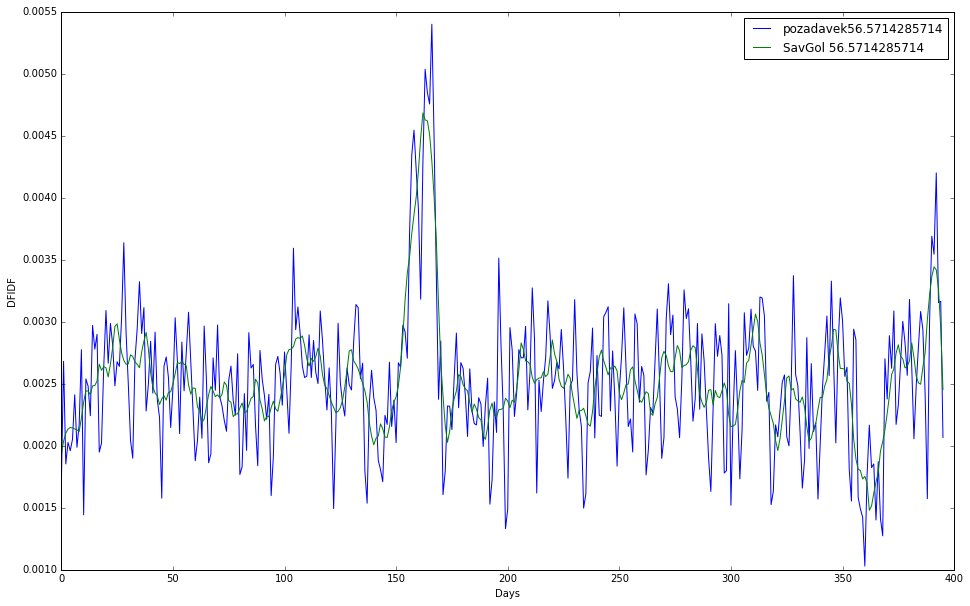

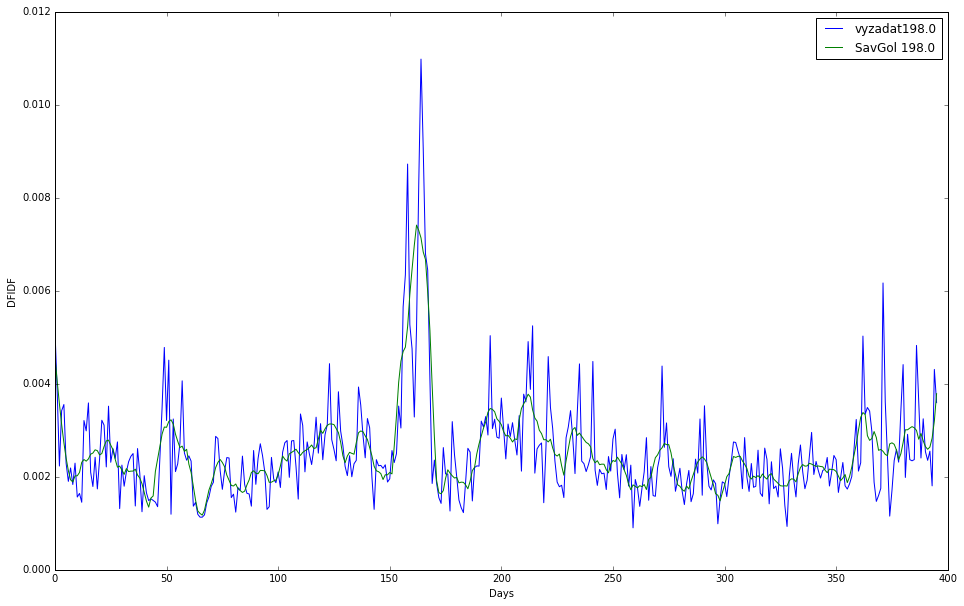

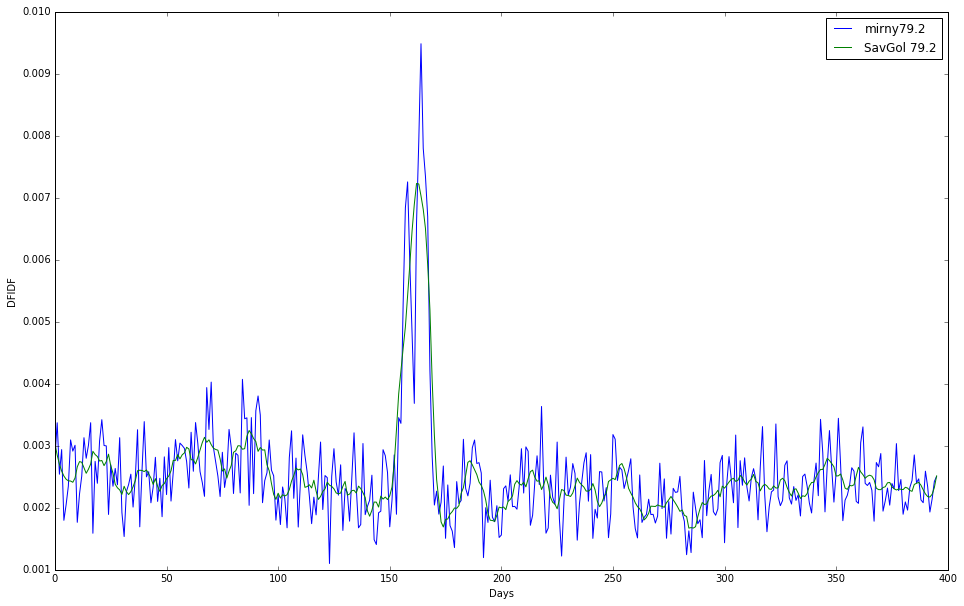

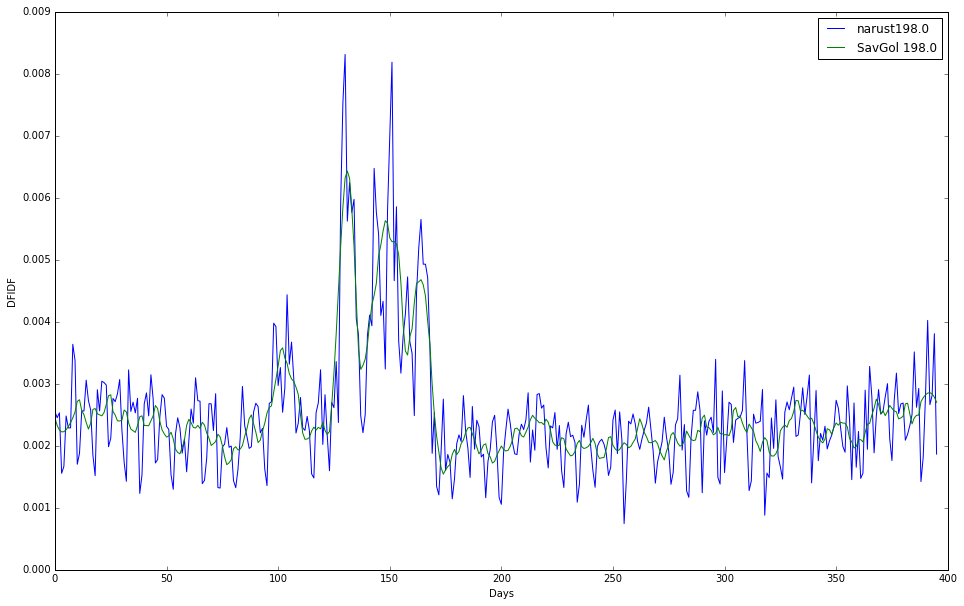

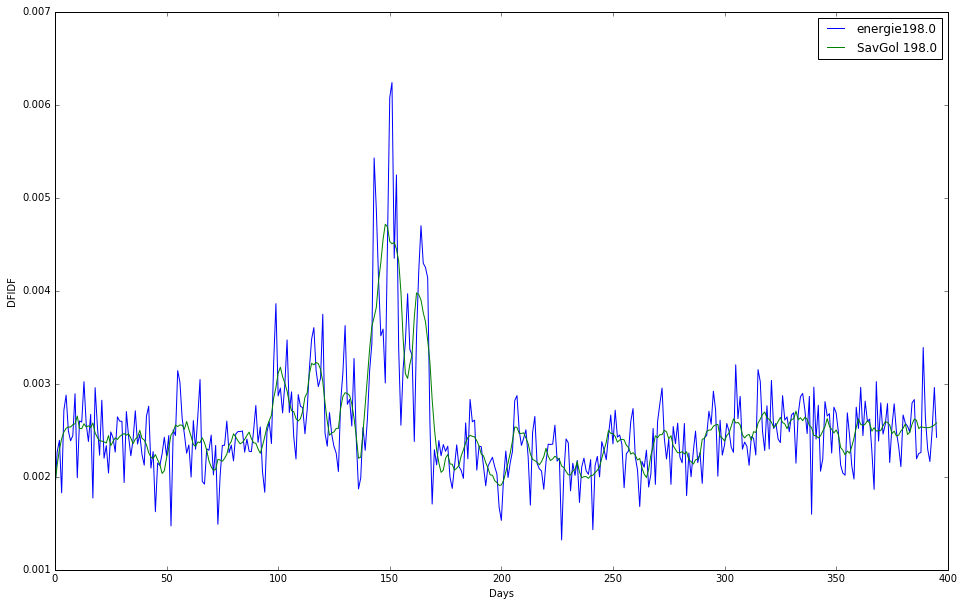

In [112]:
%matplotlib inline

from scipy.signal import convolve
from scipy.signal import bartlett, blackman, gaussian, hamming, hanning, savgol_filter

days = np.arange(stream_length)
n_points = 15

for error in errors:
    fig = plt.figure()
    word_id = vectorizer.vocabulary_[error]
    signal = trajectories[word_id]
    plt.plot(days, signal / signal.sum(), label=(error) + str(get_dominant_period(signal)))
    
#     window = bartlett(n_points, False)
#     filtered = convolve(signal / signal.sum(), window / window.sum(), 'same')
#     plt.plot(filtered / filtered.sum(), label=('Bartlett ' + str(get_dominant_period(filtered))))
    
#     window = blackman(n_points, False)
#     filtered = convolve(signal / signal.sum(), window / window.sum(), 'same')
#     plt.plot(filtered / filtered.sum(), label=('Blackman ' + str(get_dominant_period(filtered))))
    
#     window = hanning(n_points, False)
#     filtered = convolve(signal / signal.sum(), window / window.sum(), 'same')
#     plt.plot(filtered / filtered.sum(), label=('Hanning ' + str(get_dominant_period(filtered))))
    
#     window = gaussian(n_points, 2, False)
#     filtered = convolve(signal / signal.sum(), window / window.sum(), 'same')
#     plt.plot(filtered / filtered.sum(), label=('Gaussian ' + str(get_dominant_period(filtered))))
    
#     window = hamming(n_points, False)
#     filtered = convolve(signal / signal.sum(), window / window.sum(), 'same')
#     plt.plot(filtered / filtered.sum(), label=('Hamming ' + str(get_dominant_period(filtered))))
    
    filtered = savgol_filter(signal, 15, 3)
    plt.plot(filtered / filtered.sum(), label=('SavGol ' + str(get_dominant_period(filtered))))

    fig.set_size_inches(16, 10)
    plt.xlabel('Days')
    plt.ylabel('DFIDF')
    plt.legend(loc='best')
    plt.show()